<a href="https://colab.research.google.com/github/ShakambariSaxena/2-label-Classification/blob/main/2_label_classification_with_BERT_multilingual_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Installing libraires**

In [ ]:
!pip install nltk
!pip install gensim
!pip install scikit-learn

In [ ]:
import tensorflow as tf
from tensorflow import keras
import nltk
!python -m nltk.downloader popular
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
!pip install imbalanced-learn

/usr/lib/python3.10/runpy.py:126: RuntimeWarning: 'nltk.downloader' found in sys.modules after import of package 'nltk', but prior to execution of 'nltk.downloader'; this may result in unpredictable behaviour
  warn(RuntimeWarning(msg))
[nltk_data] Downloading collection 'popular'
[nltk_data]    | 
[nltk_data]    | Downloading package cmudict to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/cmudict.zip.
[nltk_data]    | Downloading package gazetteers to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/gazetteers.zip.
[nltk_data]    | Downloading package genesis to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/genesis.zip.
[nltk_data]    | Downloading package gutenberg to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/gutenberg.zip.
[nltk_data]    | Downloading package inaugural to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/inaugural.zip.
[nltk_data]    | Downloading package movie_reviews to
[nltk_data]    |     /root/nltk_data...
[nltk_d

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


**Uploading Dataset**

In [ ]:
from google.colab import files

# Upload the zip file
uploaded = files.upload()

Saving transcripts.zip to transcripts.zip


In [ ]:
import zipfile

zip_file_path = '/content/transcripts.zip'  # Replace with the actual path to your zip file
folder_to_extract = 'transcript'  # Replace with the name of the folder you want to extract

with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(folder_to_extract)

print("Folder extraction complete.")

Folder extraction complete.


In [ ]:
import os
import re

corpus_dir = '/content/transcript/transcripts'

texts = []
labels = []

folder_names = [folder for folder in os.listdir(corpus_dir) if os.path.isdir(os.path.join(corpus_dir, folder))]
folder_names.sort()

for folder_name in folder_names:
    folder_path = os.path.join(corpus_dir, folder_name)

    # Get the list of text files in the folder
    files = [file for file in os.listdir(folder_path) if file.endswith('.txt')]

    if len(files) == 1:
        # Process the single text file in the folder
        file_path = os.path.join(folder_path, files[0])
        with open(file_path, 'r') as f:
            lines = f.readlines()

            for line in lines:
                line = line.strip()
                if line:
                    match = re.search(r"['\"](.*?)\[([\d]+)\]", line)
                    if match:
                        sentence = match.group(1)
                        label = match.group(2)

                        sentence = re.sub(r'^\d+\.\s+', '', sentence)
                        sentence = re.sub(r'[^\w\s]', '', sentence)  # Remove symbols
                        sentence = sentence.lower()

                        texts.append(sentence)
                        labels.append(int(label))

    elif len(files) == 2:
        # Process Channel_1 text file
        file_path = os.path.join(folder_path, 'Channel_1.txt')
        with open(file_path, 'r') as f:
            lines = f.readlines()

            for line in lines:
                line = line.strip()
                if line:
                    match = re.search(r"['\"](.*?)\[([\d]+)\]", line)
                    if match:
                        sentence = match.group(1)
                        label = match.group(2)

                        sentence = re.sub(r'^\d+\.\s+', '', sentence)
                        sentence = re.sub(r'[^\w\s]', '', sentence)  # Remove symbols
                        sentence = sentence.lower()

                        texts.append(sentence)
                        labels.append(int(label))

        # Process Channel_2 text file
        file_path = os.path.join(folder_path, 'Channel_2.txt')
        with open(file_path, 'r') as f:
            lines = f.readlines()

            for line in lines:
                line = line.strip()
                if line:
                    match = re.search(r"['\"](.*?)\[([\d]+)\]", line)
                    if match:
                        sentence = match.group(1)
                        label = match.group(2)

                        sentence = re.sub(r'^\d+\.\s+', '', sentence)
                        sentence = re.sub(r'[^\w\s]', '', sentence)  # Remove symbols
                        sentence = sentence.lower()

                        texts.append(sentence)
                        labels.append(int(label))

# Write the text and label data to a new file in the current directory
output_file = 'dataset.txt'
with open(output_file, 'w') as f:
    for text, label in zip(texts, labels):
        line = f'{label}\t{text}\n'
        f.write(line)


**Preprocessing Dataset**

In [ ]:
from textblob import TextBlob
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer, WordNetLemmatizer

def process_text(input_file, output_file):
    english_stopwords = set(stopwords.words('english'))
    german_stopwords = set(stopwords.words('german'))
    stemmer = SnowballStemmer("german")
    lemmatizer = WordNetLemmatizer()

    with open(input_file, 'r') as file:
        lines = file.readlines()

    processed_lines = []
    for line in lines:
        label, text = line.split('\t')

        # Skip the line if the label is 4 or 1
        if label in ['4', '1']:
            continue

        blob = TextBlob(text)

        # Remove stopwords and perform stemming and lemmatization
        words = [lemmatizer.lemmatize(stemmer.stem(word.lower())) for word in blob.words
                 if word.lower() not in english_stopwords and word.lower() not in german_stopwords]

        processed_text = ' '.join(words)

        # Skip processing if line becomes blank
        if not processed_text.strip():
            continue

        processed_lines.append(f"{label}\t{processed_text}\n")

    with open(output_file, 'w') as file:
        file.writelines(processed_lines)

# Specify the paths to your input and output files
input_file = '/content/dataset.txt'
output_file = '/content/preprocessed_dataset.txt'

# Call the function to process the text file
process_text(input_file, output_file)


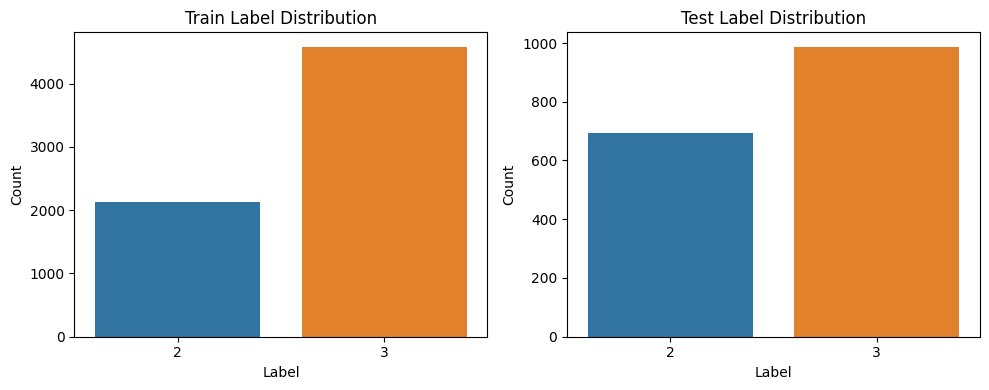

{2: 2133, 3: 4580}
{2: 692, 3: 987}


In [ ]:
import os
import random
import matplotlib.pyplot as plt
import seaborn as sns

# Step 1: Prepare the dataset
sentences = []
labels = []
with open('/content/preprocessed_dataset.txt', 'r') as file:
    for line in file:
        line = line.strip()
        if line:
            parts = line.split('\t')
            if len(parts) == 2:
                label, sentence = parts
                sentences.append(sentence)
                labels.append(int(label))

split_ratio = 0.8  # 80% for training, 20% for testing
split_index = int(len(sentences) * split_ratio)
train_sentences = sentences[:split_index]
train_labels = labels[:split_index]
test_sentences = sentences[split_index:]
test_labels = labels[split_index:]

# Step 3: Create train and test folders
train_folder = '/content/train_dataset'
test_folder = '/content/test_dataset'

os.makedirs(train_folder, exist_ok=True)
os.makedirs(test_folder, exist_ok=True)

# Save train dataset
with open(os.path.join(train_folder, 'train_dataset.txt'), 'w') as file:
    for sentence, label in zip(train_sentences, train_labels):
        file.write(f'{label}\t{sentence}\n')

# Save test dataset
with open(os.path.join(test_folder, 'test_dataset.txt'), 'w') as file:
    for sentence, label in zip(test_sentences, test_labels):
        file.write(f'{label}\t{sentence}\n')

# Step 4: Calculate label distributions
train_label_counts = {label: train_labels.count(label) for label in set(train_labels)}
test_label_counts = {label: test_labels.count(label) for label in set(test_labels)}

# Step 5: Plot label distributions
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
sns.barplot(x=list(train_label_counts.keys()), y=list(train_label_counts.values()))
plt.xlabel('Label')
plt.ylabel('Count')
plt.title('Train Label Distribution')

plt.subplot(1, 2, 2)
sns.barplot(x=list(test_label_counts.keys()), y=list(test_label_counts.values()))
plt.xlabel('Label')
plt.ylabel('Count')
plt.title('Test Label Distribution')

plt.tight_layout()
plt.show()

print(train_label_counts)
print(test_label_counts)

**Installing Libraries for BERT model**

In [ ]:
!pip install transformers
!pip install torch
!pip install transformers torch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 27.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 30.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 84.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 70.1 MB/s eta 0:00:00


**Importing libraries**

In [ ]:
import torch
from transformers import BertTokenizer, BertForSequenceClassification
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt

In [ ]:
def load_data_from_file(file_path):
    labels = []
    sentences = []
    with open(file_path, 'r', encoding='utf-8') as f:
        lines = f.readlines()
    for line in lines:
        elements = line.strip().split('\t')
        label = int(elements[0])  # Assuming the label is the first element in each line
        text = ' '.join(elements[1:])  # Combine the rest of the elements as the text
        labels.append(label)
        sentences.append(text)
    return labels, sentences


In [ ]:
# Load training data
train_file = "/content/train_dataset/train_dataset.txt"
labels_train,sentences_train = load_data_from_file(train_file)

# Load testing data
test_file = "/content/test_dataset/test_dataset.txt"
labels_test,sentences_test = load_data_from_file(test_file)

In [ ]:
# Load BERT tokenizer
tokenizer = BertTokenizer.from_pretrained("bert-base-multilingual-cased")

# Tokenize training data
tokenized_train = tokenizer(sentences_train, padding=True, truncation=True, return_tensors="pt")
input_ids_train = tokenized_train.input_ids
attention_mask_train = tokenized_train.attention_mask
labels_train = torch.tensor(labels_train)

# Tokenize testing data
tokenized_test = tokenizer(sentences_test, padding=True, truncation=True, return_tensors="pt")
input_ids_test = tokenized_test.input_ids
attention_mask_test = tokenized_test.attention_mask
labels_test = torch.tensor(labels_test)

<ipython-input-20-c5f72fda673b>:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels_train = torch.tensor(labels_train)
<ipython-input-20-c5f72fda673b>:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels_test = torch.tensor(labels_test)


**Creating train,test and validation dataset**

In [ ]:
from torch.utils.data import random_split
# Split the training data into training set and validation set (80-20 split)
train_val_dataset = TensorDataset(input_ids_train, attention_mask_train, labels_train)
train_size = int(0.8 * len(train_val_dataset))
val_size = len(train_val_dataset) - train_size
train_dataset, val_dataset = random_split(train_val_dataset, [train_size, val_size])

# Tokenize training data
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)

# Tokenize validation data
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=False)

dataset_test = TensorDataset(input_ids_test, attention_mask_test, labels_test)
test_dataloader = DataLoader(dataset_test, batch_size=32, shuffle=False)

In [ ]:
from torch.nn import Dropout
# Step 3: Load the pre-trained BERT model for sequence classification
model = BertForSequenceClassification.from_pretrained("bert-base-multilingual-cased", num_labels=(len(labels_train)))

# Add dropout layer after the BERT model
dropout_prob = 0.1  # You can adjust the dropout rate as needed
model.bert.config.hidden_dropout_prob = dropout_prob
model.dropout = Dropout(dropout_prob)

# Step 4: Fine-tuning
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Add weight decay (L2 regularization) to the optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5, weight_decay=0.01)
loss_fn = torch.nn.CrossEntropyLoss()

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


**Intializing BERT multlingual model with Cross entroply loss function**

In [ ]:
# Step 3: Load the pre-trained BERT model for sequence classification
model = BertForSequenceClassification.from_pretrained("bert-base-multilingual-cased", num_labels=(len(labels_train)))

# Step 4: Fine-tuning
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5, weight_decay=0.01)
loss_fn = torch.nn.CrossEntropyLoss()

# Training loop
num_epochs = 10
batch_size = 32
gradient_accumulation_steps = 2
num_train_steps = len(train_dataloader) // gradient_accumulation_steps
num_warmup_steps = int(0.1 * num_train_steps)

scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs * num_train_steps)

train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

best_val_loss = float("inf")
patience = 2
no_improvement = 0

for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    correct_predictions = 0
    total_predictions = 0

    for step, batch in enumerate(train_dataloader):
        batch = tuple(t.to(device) for t in batch)
        input_ids, attention_mask, labels = batch

        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        total_loss += loss.item()

        loss = loss / gradient_accumulation_steps
        loss.backward()

        if (step + 1) % gradient_accumulation_steps == 0:
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)  # Optional gradient clipping
            optimizer.step()
            optimizer.zero_grad()
            scheduler.step()

        # Calculate training accuracy
        logits = outputs.logits
        predicted_labels = torch.argmax(logits, dim=1)
        correct_predictions += (predicted_labels == labels).sum().item()
        total_predictions += labels.size(0)

    average_loss = total_loss / len(train_dataloader) * gradient_accumulation_steps
    train_losses.append(average_loss)
    train_accuracy = correct_predictions / total_predictions
    train_accuracies.append(train_accuracy)

    # Validation loop
    model.eval()
    val_loss = 0
    val_correct_predictions = 0
    val_total_predictions = 0

    with torch.no_grad():
        for batch in val_dataloader:
            batch = tuple(t.to(device) for t in batch)
            input_ids, attention_mask, labels = batch

            outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            val_loss += loss.item()

            # Calculate validation accuracy
            logits = outputs.logits
            predicted_labels = torch.argmax(logits, dim=1)
            val_correct_predictions += (predicted_labels == labels).sum().item()
            val_total_predictions += labels.size(0)

    average_val_loss = val_loss / len(val_dataloader)
    val_losses.append(average_val_loss)
    val_accuracy = val_correct_predictions / val_total_predictions
    val_accuracies.append(val_accuracy)

    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {average_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, "
          f"Validation Loss: {average_val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")

    # Early Stopping
    if average_val_loss < best_val_loss:
        best_val_loss = average_val_loss
        no_improvement = 0
    else:
        no_improvement += 1

    if no_improvement >= patience:
        print("No improvement on validation set. Finish training.")
        break

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 8.5782, Train Accuracy: 0.6588, Validation Loss: 1.6089, Validation Accuracy: 0.6701
Epoch 2/10, Train Loss: 1.8724, Train Accuracy: 0.6877, Validation Loss: 0.6247, Validation Accuracy: 0.6940
Epoch 3/10, Train Loss: 1.1150, Train Accuracy: 0.7395, Validation Loss: 0.5777, Validation Accuracy: 0.7349
Epoch 4/10, Train Loss: 0.9013, Train Accuracy: 0.8009, Validation Loss: 0.6014, Validation Accuracy: 0.7334
Epoch 5/10, Train Loss: 0.7625, Train Accuracy: 0.8345, Validation Loss: 0.5771, Validation Accuracy: 0.7431
Epoch 6/10, Train Loss: 0.6659, Train Accuracy: 0.8574, Validation Loss: 0.6099, Validation Accuracy: 0.7394
Epoch 7/10, Train Loss: 0.5848, Train Accuracy: 0.8754, Validation Loss: 0.6805, Validation Accuracy: 0.7386
No improvement on validation set. Finish training.


In [ ]:
from sklearn.metrics import classification_report
from sklearn.metrics import classification_report, confusion_matrix


model.eval()
model.to(device)

# Initialize evaluation metrics
predictions = []
true_labels = []

# Evaluate on the test data
with torch.no_grad():
    for batch in test_dataloader:
        batch = tuple(t.to(device) for t in batch)
        inputs = {"input_ids": batch[0], "attention_mask": batch[1], "labels": batch[2]}
        outputs = model(**inputs)
        logits = outputs.logits
        predicted_labels = torch.argmax(logits, dim=1)

        predictions.extend(predicted_labels.cpu().numpy())
        true_labels.extend(inputs["labels"].cpu().numpy())

# Calculate evaluation metrics
accuracy = accuracy_score(true_labels, predictions)
precision = precision_score(true_labels, predictions, average="macro")
recall = recall_score(true_labels, predictions, average="macro")
f1 = f1_score(true_labels, predictions, average="macro")

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")

# Print the classification report
target_names = ["2", "3"]  # Replace with your actual class names
print(classification_report(true_labels, predictions, target_names=target_names))

# Print the confusion matrix
conf_matrix = confusion_matrix(true_labels, predictions)
print("Confusion Matrix:")
print(conf_matrix)

Accuracy: 0.6504
Precision: 0.6486
Recall: 0.6035
F1-score: 0.5939
              precision    recall  f1-score   support

           2       0.65      0.34      0.44       692
           3       0.65      0.87      0.75       987

    accuracy                           0.65      1679
   macro avg       0.65      0.60      0.59      1679
weighted avg       0.65      0.65      0.62      1679

Confusion Matrix:
[[233 459]
 [128 859]]


**Confusion Matrix**

Confusion Matrix:
[[233 459]
 [128 859]]


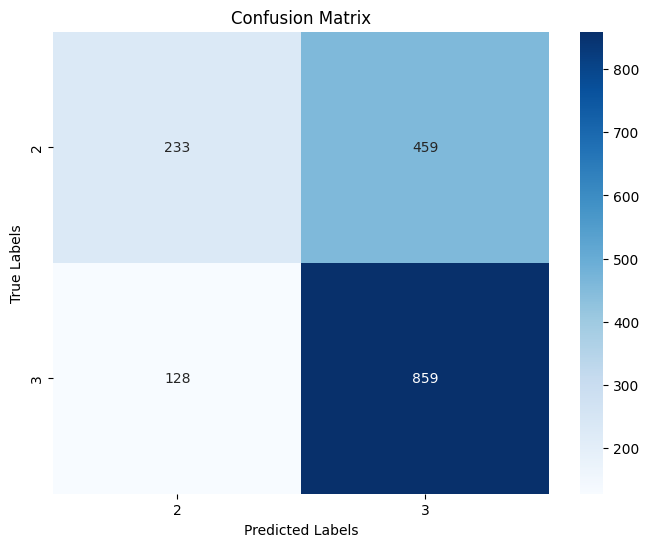

In [ ]:
import seaborn as sns

# Print the confusion matrix
conf_matrix = confusion_matrix(true_labels, predictions)
print("Confusion Matrix:")
print(conf_matrix)

# Plot the confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=target_names, yticklabels=target_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()



**Intializing BERT mulltingual model by assigning different weight to the labels**

In [ ]:
# Step 2: Load the pre-trained BERT model for sequence classification
model = BertForSequenceClassification.from_pretrained("bert-base-multilingual-cased", num_labels=len(labels_train))

# Step 3: Fine-tuning
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5, weight_decay=0.01)

# Calculate class weights manually (higher weight for class 2, the minority class)
total_samples = len(labels_train)
class_2_count = torch.sum(labels_train == 2)
class_3_count = torch.sum(labels_train == 3)

class_2_weight = total_samples / (2.0 * class_2_count)
class_3_weight = total_samples / (2.0 * class_3_count)
class_2_weight *= 2

# Convert to tensor and move to the same device as the model
class_weights = torch.tensor([class_2_weight, class_3_weight]).to(device)

loss_fn = torch.nn.CrossEntropyLoss(weight=class_weights)  # Use class weights in the loss function

# Training loop
num_epochs = 10
gradient_accumulation_steps = 2
num_train_steps = len(train_dataloader) // gradient_accumulation_steps
num_warmup_steps = int(0.1 * num_train_steps)

scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs * num_train_steps)

train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

best_val_loss = float("inf")
patience = 2
no_improvement = 0

for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    correct_predictions = 0
    total_predictions = 0

    for step, batch in enumerate(train_dataloader):
        batch = tuple(t.to(device) for t in batch)
        input_ids, attention_mask, labels = batch

        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        total_loss += loss.item()

        loss = loss / gradient_accumulation_steps
        loss.backward()

        if (step + 1) % gradient_accumulation_steps == 0:
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)  # Optional gradient clipping
            optimizer.step()
            optimizer.zero_grad()
            scheduler.step()

        # Calculate training accuracy
        logits = outputs.logits
        predicted_labels = torch.argmax(logits, dim=1)
        correct_predictions += (predicted_labels == labels).sum().item()
        total_predictions += labels.size(0)

    average_loss = total_loss / len(train_dataloader) * gradient_accumulation_steps
    train_losses.append(average_loss)
    train_accuracy = correct_predictions / total_predictions
    train_accuracies.append(train_accuracy)

    # Validation loop
    model.eval()
    val_loss = 0
    val_correct_predictions = 0
    val_total_predictions = 0

    with torch.no_grad():
        for batch in val_dataloader:
            batch = tuple(t.to(device) for t in batch)
            input_ids, attention_mask, labels = batch

            outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            val_loss += loss.item()

            # Calculate validation accuracy
            logits = outputs.logits
            predicted_labels = torch.argmax(logits, dim=1)
            val_correct_predictions += (predicted_labels == labels).sum().item()
            val_total_predictions += labels.size(0)

    average_val_loss = val_loss / len(val_dataloader)
    val_losses.append(average_val_loss)
    val_accuracy = val_correct_predictions / val_total_predictions
    val_accuracies.append(val_accuracy)

    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {average_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, "
          f"Validation Loss: {average_val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")

    # Early Stopping
    if average_val_loss < best_val_loss:
        best_val_loss = average_val_loss
        no_improvement = 0
    else:
        no_improvement += 1

    if no_improvement >= patience:
        print("No improvement on the validation set. Finish training.")
        break


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 8.4635, Train Accuracy: 0.6594, Validation Loss: 1.5868, Validation Accuracy: 0.6858
Epoch 2/10, Train Loss: 1.9213, Train Accuracy: 0.6804, Validation Loss: 0.6332, Validation Accuracy: 0.6858
Epoch 3/10, Train Loss: 1.1565, Train Accuracy: 0.7223, Validation Loss: 0.5353, Validation Accuracy: 0.7558
Epoch 4/10, Train Loss: 0.9669, Train Accuracy: 0.7804, Validation Loss: 0.5681, Validation Accuracy: 0.7550
Epoch 5/10, Train Loss: 0.8396, Train Accuracy: 0.8112, Validation Loss: 0.5376, Validation Accuracy: 0.7558
No improvement on the validation set. Finish training.


In [ ]:
from sklearn.metrics import classification_report
from sklearn.metrics import classification_report, confusion_matrix


model.eval()
model.to(device)

# Initialize evaluation metrics
predictions = []
true_labels = []

# Evaluate on the test data
with torch.no_grad():
    for batch in test_dataloader:
        batch = tuple(t.to(device) for t in batch)
        inputs = {"input_ids": batch[0], "attention_mask": batch[1], "labels": batch[2]}
        outputs = model(**inputs)
        logits = outputs.logits
        predicted_labels = torch.argmax(logits, dim=1)

        predictions.extend(predicted_labels.cpu().numpy())
        true_labels.extend(inputs["labels"].cpu().numpy())

# Calculate evaluation metrics
accuracy = accuracy_score(true_labels, predictions)
precision = precision_score(true_labels, predictions, average="macro")
recall = recall_score(true_labels, predictions, average="macro")
f1 = f1_score(true_labels, predictions, average="macro")

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")

# Print the classification report
target_names = ["2", "3"]  # Replace with your actual class names
print(classification_report(true_labels, predictions, target_names=target_names))

# Print the confusion matrix
conf_matrix = confusion_matrix(true_labels, predictions)
print("Confusion Matrix:")
print(conf_matrix)

Accuracy: 0.6808
Precision: 0.6920
Recall: 0.6356
F1-score: 0.6305
              precision    recall  f1-score   support

           2       0.71      0.38      0.49       692
           3       0.67      0.89      0.77       987

    accuracy                           0.68      1679
   macro avg       0.69      0.64      0.63      1679
weighted avg       0.69      0.68      0.65      1679

Confusion Matrix:
[[262 430]
 [106 881]]


**Confusion Matrix when class weight assigned**

Confusion Matrix:
[[262 430]
 [106 881]]


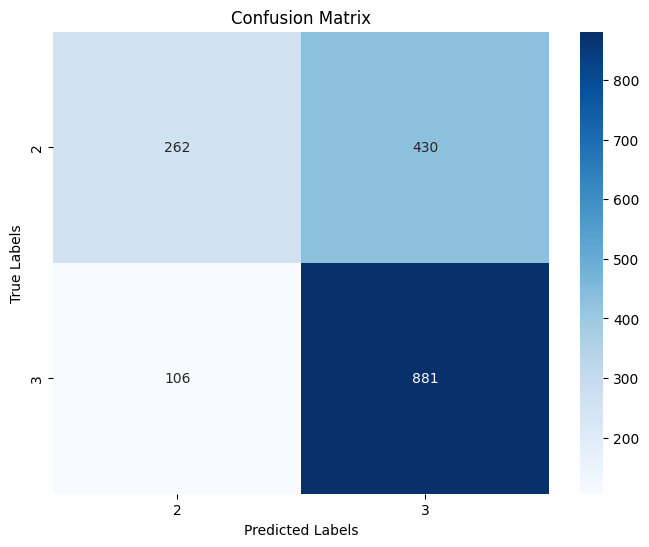

In [ ]:
import seaborn as sns

# Print the confusion matrix
conf_matrix = confusion_matrix(true_labels, predictions)
print("Confusion Matrix:")
print(conf_matrix)

# Plot the confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=target_names, yticklabels=target_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()



**BERT model with Smoothed Cross Entropy loss function**

In [ ]:
class SmoothedCrossEntropyLoss(torch.nn.Module):
    def __init__(self, smoothing=0.1, weight=None):
        super(SmoothedCrossEntropyLoss, self).__init__()
        self.smoothing = smoothing
        self.weight = weight

    def forward(self, inputs, targets):
        log_prob = torch.nn.functional.log_softmax(inputs, dim=-1)
        nll_loss = -log_prob.gather(dim=-1, index=targets.unsqueeze(1))
        nll_loss = nll_loss.squeeze(1)

        smooth_loss = -log_prob.mean(dim=-1)

        if self.weight is not None:
            nll_loss = nll_loss * self.weight
            smooth_loss = smooth_loss * self.weight

        loss = (1.0 - self.smoothing) * nll_loss + self.smoothing * smooth_loss
        return loss.mean()

# Change the loss function to SmoothedCrossEntropyLoss
loss_fn = SmoothedCrossEntropyLoss(smoothing=0.1)



In [ ]:
# Step 2: Load the pre-trained BERT model for sequence classification
model = BertForSequenceClassification.from_pretrained("bert-base-multilingual-cased", num_labels=len(labels_train))

# Step 3: Fine-tuning
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5, weight_decay=0.01)

# Calculate class weights manually (higher weight for class 2, the minority class)
total_samples = len(labels_train)
class_2_count = torch.sum(labels_train == 2)
class_3_count = torch.sum(labels_train == 3)

class_2_weight = total_samples / (2.0 * class_2_count)
class_3_weight = total_samples / (2.0 * class_3_count)
class_2_weight *= 2

# Convert to tensor and move to the same device as the model
class_weights = torch.tensor([class_2_weight, class_3_weight]).to(device)

loss_fn = SmoothedCrossEntropyLoss(smoothing=0.1)


# Training loop
num_epochs = 10
gradient_accumulation_steps = 2
num_train_steps = len(train_dataloader) // gradient_accumulation_steps
num_warmup_steps = int(0.1 * num_train_steps)

scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs * num_train_steps)

train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

best_val_loss = float("inf")
patience = 2
no_improvement = 0

for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    correct_predictions = 0
    total_predictions = 0

    for step, batch in enumerate(train_dataloader):
        batch = tuple(t.to(device) for t in batch)
        input_ids, attention_mask, labels = batch

        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        total_loss += loss.item()

        loss = loss / gradient_accumulation_steps
        loss.backward()

        if (step + 1) % gradient_accumulation_steps == 0:
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)  # Optional gradient clipping
            optimizer.step()
            optimizer.zero_grad()
            scheduler.step()

        # Calculate training accuracy
        logits = outputs.logits
        predicted_labels = torch.argmax(logits, dim=1)
        correct_predictions += (predicted_labels == labels).sum().item()
        total_predictions += labels.size(0)

    average_loss = total_loss / len(train_dataloader) * gradient_accumulation_steps
    train_losses.append(average_loss)
    train_accuracy = correct_predictions / total_predictions
    train_accuracies.append(train_accuracy)

    # Validation loop
    model.eval()
    val_loss = 0
    val_correct_predictions = 0
    val_total_predictions = 0

    with torch.no_grad():
        for batch in val_dataloader:
            batch = tuple(t.to(device) for t in batch)
            input_ids, attention_mask, labels = batch

            outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            val_loss += loss.item()

            # Calculate validation accuracy
            logits = outputs.logits
            predicted_labels = torch.argmax(logits, dim=1)
            val_correct_predictions += (predicted_labels == labels).sum().item()
            val_total_predictions += labels.size(0)

    average_val_loss = val_loss / len(val_dataloader)
    val_losses.append(average_val_loss)
    val_accuracy = val_correct_predictions / val_total_predictions
    val_accuracies.append(val_accuracy)

    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {average_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, "
          f"Validation Loss: {average_val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")

    # Early Stopping
    if average_val_loss < best_val_loss:
        best_val_loss = average_val_loss
        no_improvement = 0
    else:
        no_improvement += 1

    if no_improvement >= patience:
        print("No improvement on the validation set. Finish training.")
        break


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 8.3329, Train Accuracy: 0.6549, Validation Loss: 1.4648, Validation Accuracy: 0.6806
Epoch 2/10, Train Loss: 1.8125, Train Accuracy: 0.6827, Validation Loss: 0.6520, Validation Accuracy: 0.6806
Epoch 3/10, Train Loss: 1.1994, Train Accuracy: 0.7041, Validation Loss: 0.5262, Validation Accuracy: 0.7476
Epoch 4/10, Train Loss: 0.9821, Train Accuracy: 0.7832, Validation Loss: 0.5127, Validation Accuracy: 0.7476
Epoch 5/10, Train Loss: 0.8490, Train Accuracy: 0.8115, Validation Loss: 0.5071, Validation Accuracy: 0.7669
Epoch 6/10, Train Loss: 0.7334, Train Accuracy: 0.8438, Validation Loss: 0.5342, Validation Accuracy: 0.7617
Epoch 7/10, Train Loss: 0.6465, Train Accuracy: 0.8654, Validation Loss: 0.5502, Validation Accuracy: 0.7543
No improvement on the validation set. Finish training.


In [ ]:
from sklearn.metrics import classification_report
from sklearn.metrics import classification_report, confusion_matrix


model.eval()
model.to(device)

# Initialize evaluation metrics
predictions = []
true_labels = []

# Evaluate on the test data
with torch.no_grad():
    for batch in test_dataloader:
        batch = tuple(t.to(device) for t in batch)
        inputs = {"input_ids": batch[0], "attention_mask": batch[1], "labels": batch[2]}
        outputs = model(**inputs)
        logits = outputs.logits
        predicted_labels = torch.argmax(logits, dim=1)

        predictions.extend(predicted_labels.cpu().numpy())
        true_labels.extend(inputs["labels"].cpu().numpy())

# Calculate evaluation metrics
accuracy = accuracy_score(true_labels, predictions)
precision = precision_score(true_labels, predictions, average="macro")
recall = recall_score(true_labels, predictions, average="macro")
f1 = f1_score(true_labels, predictions, average="macro")

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")

# Print the classification report
target_names = ["2", "3"]  # Replace with your actual class names
print(classification_report(true_labels, predictions, target_names=target_names))

# Print the confusion matrix
conf_matrix = confusion_matrix(true_labels, predictions)
print("Confusion Matrix:")
print(conf_matrix)

Accuracy: 0.6617
Precision: 0.6686
Recall: 0.6134
F1-score: 0.6036
              precision    recall  f1-score   support

           2       0.68      0.34      0.45       692
           3       0.66      0.89      0.76       987

    accuracy                           0.66      1679
   macro avg       0.67      0.61      0.60      1679
weighted avg       0.67      0.66      0.63      1679

Confusion Matrix:
[[234 458]
 [110 877]]


**BERT model with Focal Loss function**

In [ ]:
class FocalLoss(torch.nn.Module):
    def __init__(self, alpha=0.25, gamma=2.0):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma

    def forward(self, inputs, targets):
        log_prob = torch.nn.functional.log_softmax(inputs, dim=-1)
        prob = torch.exp(log_prob)
        focal_weight = (self.alpha * targets + (1 - self.alpha) * (1 - targets)) * (1 - prob) ** self.gamma
        cross_entropy = -log_prob.gather(dim=-1, index=targets.unsqueeze(1))
        loss = focal_weight * cross_entropy
        return loss.mean()

# Change the loss function to FocalLoss
loss_fn = FocalLoss(alpha=0.25, gamma=2.0)


In [ ]:
# Step 2: Load the pre-trained BERT model for sequence classification
model = BertForSequenceClassification.from_pretrained("bert-base-multilingual-cased", num_labels=len(labels_train))

# Step 3: Fine-tuning
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5, weight_decay=0.01)

# Calculate class weights manually (higher weight for class 2, the minority class)
total_samples = len(labels_train)
class_2_count = torch.sum(labels_train == 2)
class_3_count = torch.sum(labels_train == 3)

class_2_weight = total_samples / (2.0 * class_2_count)
class_3_weight = total_samples / (2.0 * class_3_count)
class_2_weight *= 2

# Convert to tensor and move to the same device as the model
class_weights = torch.tensor([class_2_weight, class_3_weight]).to(device)

loss_fn = FocalLoss(alpha=0.25, gamma=2.0)

# Training loop
num_epochs = 10
gradient_accumulation_steps = 2
num_train_steps = len(train_dataloader) // gradient_accumulation_steps
num_warmup_steps = int(0.1 * num_train_steps)

scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs * num_train_steps)

train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

best_val_loss = float("inf")
patience = 2
no_improvement = 0

for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    correct_predictions = 0
    total_predictions = 0

    for step, batch in enumerate(train_dataloader):
        batch = tuple(t.to(device) for t in batch)
        input_ids, attention_mask, labels = batch

        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        total_loss += loss.item()

        loss = loss / gradient_accumulation_steps
        loss.backward()

        if (step + 1) % gradient_accumulation_steps == 0:
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)  # Optional gradient clipping
            optimizer.step()
            optimizer.zero_grad()
            scheduler.step()

        # Calculate training accuracy
        logits = outputs.logits
        predicted_labels = torch.argmax(logits, dim=1)
        correct_predictions += (predicted_labels == labels).sum().item()
        total_predictions += labels.size(0)

    average_loss = total_loss / len(train_dataloader) * gradient_accumulation_steps
    train_losses.append(average_loss)
    train_accuracy = correct_predictions / total_predictions
    train_accuracies.append(train_accuracy)

    # Validation loop
    model.eval()
    val_loss = 0
    val_correct_predictions = 0
    val_total_predictions = 0

    with torch.no_grad():
        for batch in val_dataloader:
            batch = tuple(t.to(device) for t in batch)
            input_ids, attention_mask, labels = batch

            outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            val_loss += loss.item()

            # Calculate validation accuracy
            logits = outputs.logits
            predicted_labels = torch.argmax(logits, dim=1)
            val_correct_predictions += (predicted_labels == labels).sum().item()
            val_total_predictions += labels.size(0)

    average_val_loss = val_loss / len(val_dataloader)
    val_losses.append(average_val_loss)
    val_accuracy = val_correct_predictions / val_total_predictions
    val_accuracies.append(val_accuracy)

    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {average_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, "
          f"Validation Loss: {average_val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")

    # Early Stopping
    if average_val_loss < best_val_loss:
        best_val_loss = average_val_loss
        no_improvement = 0
    else:
        no_improvement += 1

    if no_improvement >= patience:
        print("No improvement on the validation set. Finish training.")
        break


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 8.8577, Train Accuracy: 0.6577, Validation Loss: 1.7462, Validation Accuracy: 0.6806
Epoch 2/10, Train Loss: 2.0453, Train Accuracy: 0.6875, Validation Loss: 0.6129, Validation Accuracy: 0.7215
Epoch 3/10, Train Loss: 1.1657, Train Accuracy: 0.7393, Validation Loss: 0.5511, Validation Accuracy: 0.7446
Epoch 4/10, Train Loss: 0.9688, Train Accuracy: 0.7862, Validation Loss: 0.5462, Validation Accuracy: 0.7461
Epoch 5/10, Train Loss: 0.8240, Train Accuracy: 0.8266, Validation Loss: 0.5666, Validation Accuracy: 0.7558
Epoch 6/10, Train Loss: 0.7201, Train Accuracy: 0.8557, Validation Loss: 0.5524, Validation Accuracy: 0.7610
No improvement on the validation set. Finish training.


In [ ]:
from sklearn.metrics import classification_report
from sklearn.metrics import classification_report, confusion_matrix


model.eval()
model.to(device)

# Initialize evaluation metrics
predictions = []
true_labels = []

# Evaluate on the test data
with torch.no_grad():
    for batch in test_dataloader:
        batch = tuple(t.to(device) for t in batch)
        inputs = {"input_ids": batch[0], "attention_mask": batch[1], "labels": batch[2]}
        outputs = model(**inputs)
        logits = outputs.logits
        predicted_labels = torch.argmax(logits, dim=1)

        predictions.extend(predicted_labels.cpu().numpy())
        true_labels.extend(inputs["labels"].cpu().numpy())

# Calculate evaluation metrics
accuracy = accuracy_score(true_labels, predictions)
precision = precision_score(true_labels, predictions, average="macro")
recall = recall_score(true_labels, predictions, average="macro")
f1 = f1_score(true_labels, predictions, average="macro")

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")

# Print the classification report
target_names = ["2", "3"]  # Replace with your actual class names
print(classification_report(true_labels, predictions, target_names=target_names))

# Print the confusion matrix
conf_matrix = confusion_matrix(true_labels, predictions)
print("Confusion Matrix:")
print(conf_matrix)

Accuracy: 0.6593
Precision: 0.6627
Recall: 0.6122
F1-score: 0.6033
              precision    recall  f1-score   support

           2       0.67      0.34      0.45       692
           3       0.66      0.88      0.75       987

    accuracy                           0.66      1679
   macro avg       0.66      0.61      0.60      1679
weighted avg       0.66      0.66      0.63      1679

Confusion Matrix:
[[238 454]
 [118 869]]


**BERT model with Binary Loss function**

In [ ]:
class BinaryCrossEntropyLoss(torch.nn.Module):
    def __init__(self, weight=None):
        super(BinaryCrossEntropyLoss, self).__init__()
        self.weight = weight

    def forward(self, inputs, targets):
        loss_fn = torch.nn.BCEWithLogitsLoss(weight=self.weight)
        return loss_fn(inputs.view(-1), targets.view(-1).float())

# Use BinaryCrossEntropyLoss as the loss function
loss_fn = BinaryCrossEntropyLoss()


In [ ]:
# Step 2: Load the pre-trained BERT model for sequence classification
model = BertForSequenceClassification.from_pretrained("bert-base-multilingual-cased", num_labels=len(labels_train))

# Step 3: Fine-tuning
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5, weight_decay=0.01)

# Calculate class weights manually (higher weight for class 2, the minority class)
total_samples = len(labels_train)
class_2_count = torch.sum(labels_train == 2)
class_3_count = torch.sum(labels_train == 3)

class_2_weight = total_samples / (2.0 * class_2_count)
class_3_weight = total_samples / (2.0 * class_3_count)
class_2_weight *= 2

# Convert to tensor and move to the same device as the model
class_weights = torch.tensor([class_2_weight, class_3_weight]).to(device)

loss_fn = BinaryCrossEntropyLoss()


# Training loop
num_epochs = 10
gradient_accumulation_steps = 2
num_train_steps = len(train_dataloader) // gradient_accumulation_steps
num_warmup_steps = int(0.1 * num_train_steps)

scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs * num_train_steps)

train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

best_val_loss = float("inf")
patience = 2
no_improvement = 0

for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    correct_predictions = 0
    total_predictions = 0

    for step, batch in enumerate(train_dataloader):
        batch = tuple(t.to(device) for t in batch)
        input_ids, attention_mask, labels = batch

        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        total_loss += loss.item()

        loss = loss / gradient_accumulation_steps
        loss.backward()

        if (step + 1) % gradient_accumulation_steps == 0:
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)  # Optional gradient clipping
            optimizer.step()
            optimizer.zero_grad()
            scheduler.step()

        # Calculate training accuracy
        logits = outputs.logits
        predicted_labels = torch.argmax(logits, dim=1)
        correct_predictions += (predicted_labels == labels).sum().item()
        total_predictions += labels.size(0)

    average_loss = total_loss / len(train_dataloader) * gradient_accumulation_steps
    train_losses.append(average_loss)
    train_accuracy = correct_predictions / total_predictions
    train_accuracies.append(train_accuracy)

    # Validation loop
    model.eval()
    val_loss = 0
    val_correct_predictions = 0
    val_total_predictions = 0

    with torch.no_grad():
        for batch in val_dataloader:
            batch = tuple(t.to(device) for t in batch)
            input_ids, attention_mask, labels = batch

            outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            val_loss += loss.item()

            # Calculate validation accuracy
            logits = outputs.logits
            predicted_labels = torch.argmax(logits, dim=1)
            val_correct_predictions += (predicted_labels == labels).sum().item()
            val_total_predictions += labels.size(0)

    average_val_loss = val_loss / len(val_dataloader)
    val_losses.append(average_val_loss)
    val_accuracy = val_correct_predictions / val_total_predictions
    val_accuracies.append(val_accuracy)

    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {average_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, "
          f"Validation Loss: {average_val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")

    # Early Stopping
    if average_val_loss < best_val_loss:
        best_val_loss = average_val_loss
        no_improvement = 0
    else:
        no_improvement += 1

    if no_improvement >= patience:
        print("No improvement on the validation set. Finish training.")
        break


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 8.8577, Train Accuracy: 0.6577, Validation Loss: 1.7462, Validation Accuracy: 0.6806
Epoch 2/10, Train Loss: 2.0453, Train Accuracy: 0.6875, Validation Loss: 0.6129, Validation Accuracy: 0.7215
Epoch 3/10, Train Loss: 1.1657, Train Accuracy: 0.7393, Validation Loss: 0.5511, Validation Accuracy: 0.7446
